---

<center>
<h1>Pronóstico de la productividad forrajera y balance</h1>
<h1>hídrico en la región de los pastizales del Río de la Plata</h1>
</center>

---


<br>
<br>
<ul>
    <li>Bartol, Tomás Augusto</li>
    <li>Peiretti, Pablo </li>
    <li>Sánchez, Milagros Verónica </li>
</li>
</ul>


<br>
<h2>Abstract</h2>

This notebook was created with the purpose of introducing the use of multispectral satellite images as a tool for predicting forage production and water balance in the grasslands of the Río de la Plata. Based on this, the aim is to achieve a more efficient and precise management of resources. Additionally, there will be an attempt to increase livestock productivity by reducing variability in forage production. 

---

# Modules 

This section contains the import statements for external Python modules that are used throughout the notebook. This section is where external libraries or packages are loaded in order to provide additional functionality beyond the basic Python capabilities


In [1]:
### Load the modules ### 
import sys
import tensorflow as tf
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import ipywidgets as widgets
from folium import plugins
from shapely.geometry import Polygon
from shapely.geometry import MultiPoint, MultiPolygon
from sklearn.cluster import KMeans
import folium
from branca.colormap import linear

### Load In-House modules ###  
sys.path.append('../src/')
import data
import reporting
import models


--- 

# Macros 

The Globals and Macros section in this codebase serves as a centralized hub for managing global variables and macros that impact the entire project. This section is dedicated to storing constants, configuration parameters, and reusable macros that streamline the development process and ensure consistency across various components.

In [2]:
#DATABASE_PATH = "Database\database.csv"
SAMPLES_PER_LOCATION = 460
COLORS = ['red', 'blue', 'green', 'purple', 'orange', 'darkred', \
     'lightred', 'darkblue', 'darkgreen', 'cadetblue', \
     'darkpurple', 'pink', 'lightblue', 'lightgreen', 'gray', \
     'black', 'lightgray', 'red', 'blue', 'green', 'purple', \
     'orange', 'darkred', 'lightred', 'beige', 'darkblue', \
     'darkgreen', 'cadetblue', 'darkpurple','pink', 'lightblue', \
     'lightgreen', 'gray', 'black', 'lightgray', 'beige' ]
CLUSTERS_QTY = 8

---

# Data

In this dedicated segment, our primary emphasis will be on the comprehensive visualization and skillful manipulation of the data provided by the MODIS remote sensor. We will delve into the intricacies of presenting the information in a visually impactful manner, ensuring that we not only harness the power of visualization techniques but also adeptly navigate the nuances of manipulating the MODIS dataset for meaningful insights.

In [3]:
ppna_df = data.ppna_database_ingest('PPNA_denso_16d_fechas_ordenadas.csv')
temp_df = data.temp_database_ingest('TEMP_denso_16d_fechas_ordenadas.csv')
ppt_df = data.ppt_database_ingest('PPT_denso_16d_fechas_ordenadas.csv')
date_df = data.date_database_ingest('fechas modis ANII.csv')
cord_df = data.cord_database_ingest ('xy_denso.csv')
ppna_df_feature_cross = data.DataManager(data.merge_databases(ppna_df,temp_df,ppt_df,cord_df,date_df))
ppna_df_feature_cross.info()

<class 'data.data_manager.DataManager'>
RangeIndex: 690000 entries, 0 to 689999
Data columns (total 6 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   ppna       690000 non-null  float64       
 1   temp       690000 non-null  float64       
 2   ppt        690000 non-null  float64       
 3   date       690000 non-null  datetime64[ns]
 4   latitude   690000 non-null  float64       
 5   longitude  690000 non-null  float64       
dtypes: datetime64[ns](1), float64(5)
memory usage: 31.6 MB



## Data Visualization 


In [11]:
ppna_df_feature_cross.head()

,ppna,temp,ppt,date,latitude,longitude
0,405.340618,24.333897,76.155505,2001-01-01,-31.544792,-56.83242
1,362.433361,23.921929,91.647396,2001-01-17,-31.544792,-56.83242
2,420.441046,24.132180,80.999538,2001-02-02,-31.544792,-56.83242
3,335.261458,26.170466,88.673292,2001-02-18,-31.544792,-56.83242
4,301.399079,24.043910,5.496469,2001-03-06,-31.544792,-56.83242


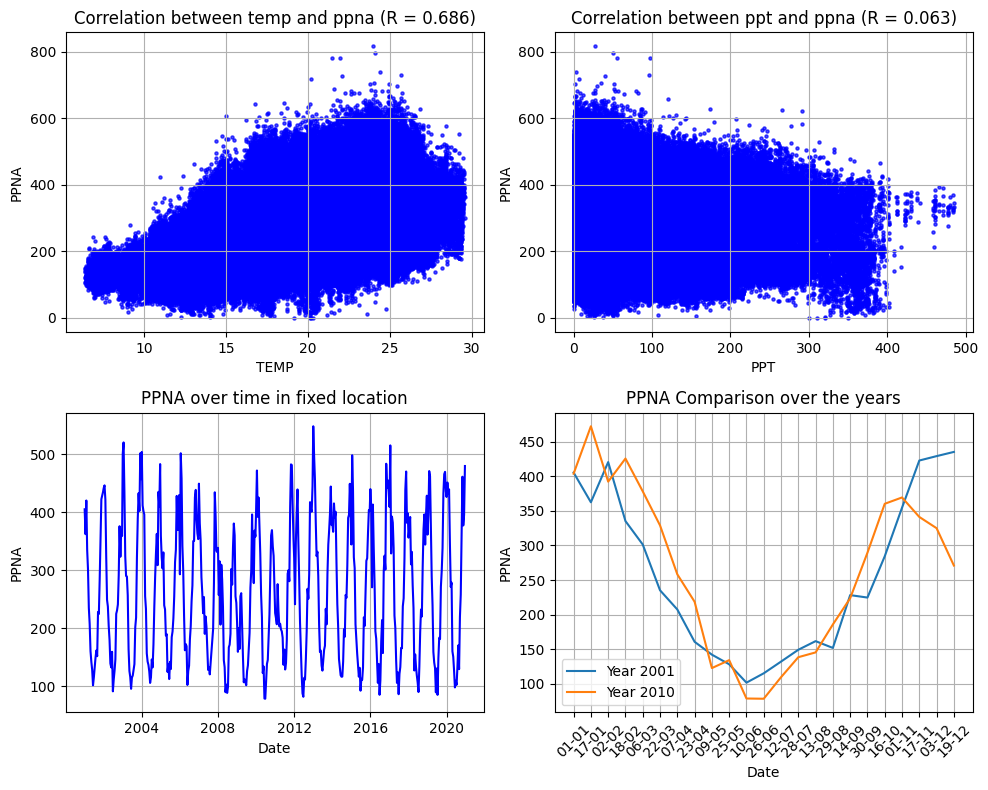

In [12]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 8))

reporting.show_correlation(ppna_df_feature_cross, axes[0,0], 'temp', 'ppna')
reporting.show_correlation(ppna_df_feature_cross, axes[0,1], 'ppt', 'ppna')
reporting.show_ppna_fixed_position(ppna_df_feature_cross, axes[1,0], ppna_df_feature_cross['latitude'][100], ppna_df_feature_cross['longitude'][100])
reporting.show_ppna_year_comparision_fixed_position(ppna_df_feature_cross,axes[1,1], 2001, 2010, ppna_df_feature_cross['latitude'][0], ppna_df_feature_cross['longitude'][0])

fig.tight_layout()
plt.show()

## Data Clustering
We employ the KMeans algorithm to cluster latitude and longitude data into geographic clusters, allowing us to identify spatial patterns and segment similar areas. This technique enriches our data with contextual information about geographical location, potentially enhancing the predictive capability of our neural network by capturing more complex spatial relationships and patterns otherwise representing Lat and Long as floating-points would provide almost no predictive power
Kmeans uses vector quantization and aims to assign each observation to the cluster with the nearest mean or centroid, which serves as a prototype for the cluster. The goal is to minimize the sum of squared distances between the data points and their corresponding cluster centroids, resulting in clusters that are internally homogeneous and distinct from each other.




In [4]:

X = ppna_df_feature_cross[['latitude', 'longitude']]
kmeans = KMeans(
    init="random",
    n_clusters=CLUSTERS_QTY,
    n_init=10,
    max_iter=300,
    random_state=42
).fit(X)

labels = kmeans.labels_
X['cluster'] = labels


C:\Users\Michi\AppData\Local\Temp\ipykernel_6736\3129208140.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['cluster'] = labels


In [5]:
centers = kmeans.cluster_centers_
print(centers)

[[-32.96561138 -56.16084226]
 [-30.74992528 -57.4256069 ]
 [-31.38522276 -57.33303046]
 [-32.94988952 -56.81693907]
 [-30.4463202  -56.89231138]
 [-31.01473872 -56.56030095]
 [-32.28556286 -56.19177935]
 [-32.22637987 -56.81737086]]


Map of Clustering Classyfication separated by color

In [6]:
map = folium.Map(location=[ppna_df_feature_cross['latitude'].mean(), ppna_df_feature_cross['longitude'].mean()], zoom_start=6)
counter = 0
for _, row in X.iterrows():

    if counter % SAMPLES_PER_LOCATION == 0:
        folium.CircleMarker(
            location=[row["latitude"], row["longitude"]],
            radius=8, 
            weight=2, 
            fill=True, 
            fill_color=COLORS[int(row["cluster"])],
            color=COLORS[int(row["cluster"])]
        ).add_to(map)
    

    counter += 1
map


In [35]:
'''
Plot every centroid on the map, color coded by the cluster they belong to
'''

map = folium.Map(location=[ppna_df_feature_cross['latitude'].mean(), ppna_df_feature_cross['longitude'].mean()], zoom_start=6)

counter = 0
for centroid in centers:

    folium.CircleMarker(
        location=[centroid[0], centroid[1]],
        radius=4, 
        weight=2, 
        fill=True, 
        fill_color=COLORS[counter],
        color=COLORS[counter]
        ).add_to(map)

    counter += 1

map

In [36]:
'''
Prints map with cluster contours obtained from the dataset locations. It uses a convex_hull (hull= shell, contour)
which sets the simplest contour to be drawn around a given set of points (like a rubber band on tacks)
'''


#Create a dictionary with points grouped by clusters. The cluster id is the dictionary key and the coordinates are the dictionary data
clustered_points = {}
for _, row in X.iterrows():
    cluster_id = int(row["cluster"])
    if cluster_id not in clustered_points:
        clustered_points[cluster_id] = []
    clustered_points[cluster_id].append((row["latitude"], row["longitude"]))

# Create a polygon dictionary. Key=cluster id; data=convex hull.
cluster_polygons = {}
for cluster_id, points in clustered_points.items():
    multipoint = MultiPoint(points)
    convex_hull = multipoint.convex_hull
    cluster_polygons[cluster_id] = convex_hull

map = folium.Map(location=[ppna_df_feature_cross['latitude'].mean(), ppna_df_feature_cross['longitude'].mean()], zoom_start=6)

for cluster_id, polygon in cluster_polygons.items():
    coords = list(polygon.exterior.coords)
    folium.Polygon(locations=coords, color=COLORS[cluster_id], fill=True, fill_color=COLORS[cluster_id], fill_opacity=0.3).add_to(map)


map

## Data Management

In [7]:
#Create df with one hot encoding
one_hot_df = pd.get_dummies(pd.Series(kmeans.labels_), prefix='cluster')

#Turn 1s and 0s into int
one_hot_df = one_hot_df.astype(bool).astype(int)

#Add one hot encoded clusters to original df
ppna_df_feature_cross = pd.concat([ppna_df_feature_cross, one_hot_df], axis=1)

In [8]:
ppna_df_feature_cross.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 690000 entries, 0 to 689999
Data columns (total 14 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   ppna       690000 non-null  float64       
 1   temp       690000 non-null  float64       
 2   ppt        690000 non-null  float64       
 3   date       690000 non-null  datetime64[ns]
 4   latitude   690000 non-null  float64       
 5   longitude  690000 non-null  float64       
 6   cluster_0  690000 non-null  int32         
 7   cluster_1  690000 non-null  int32         
 8   cluster_2  690000 non-null  int32         
 9   cluster_3  690000 non-null  int32         
 10  cluster_4  690000 non-null  int32         
 11  cluster_5  690000 non-null  int32         
 12  cluster_6  690000 non-null  int32         
 13  cluster_7  690000 non-null  int32         
dtypes: datetime64[ns](1), float64(5), int32(8)
memory usage: 52.6 MB


In [9]:
"""
Convert from date to timestamp format REVISAR
""" 
ppna_df_feature_cross['date'] = pd.to_datetime(ppna_df_feature_cross['date'])
ppna_df_feature_cross['timestamp_date'] = pd.to_datetime(ppna_df_feature_cross['date'], format='%m-%d-%Y').map(pd.Timestamp.timestamp)


In [58]:
ppna_df_feature_cross.head()


,ppna,temp,ppt,date,latitude,longitude,cluster_0,cluster_1,cluster_2,cluster_3,cluster_4,cluster_5,cluster_6,cluster_7,timestamp_date,date_signal
0,405.340618,24.333897,76.155505,2001-01-01,-31.544792,-56.83242,0,0,1,0,0,0,0,0,978307200.0,0.008300
1,362.433361,23.921929,91.647396,2001-01-17,-31.544792,-56.83242,0,0,1,0,0,0,0,0,979689600.0,0.279761
2,420.441046,24.132180,80.999538,2001-02-02,-31.544792,-56.83242,0,0,1,0,0,0,0,0,981072000.0,0.530160
3,335.261458,26.170466,88.673292,2001-02-18,-31.544792,-56.83242,0,0,1,0,0,0,0,0,982454400.0,0.740648
4,301.399079,24.043910,5.496469,2001-03-06,-31.544792,-56.83242,0,0,1,0,0,0,0,0,983836800.0,0.895377


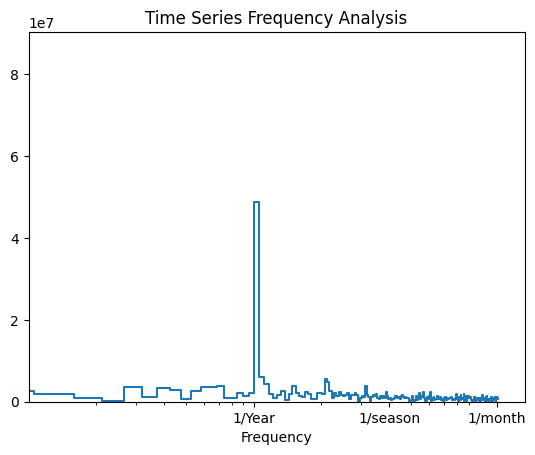

In [10]:
"""
Temporal periodicity analysis of our data set, where it can be seen that it has a very important annual periodicity.
"""

# group dataframe by date 
combined_series = ppna_df_feature_cross.groupby(['date'])['ppna'].sum().sort_index()


# Apply FFT
fft = tf.signal.rfft(combined_series)
f_per_dataset = np.arange(0, len(fft))


n_samples_h = len(combined_series)
f_sample = 15 #1 sample every 15 days 
years_per_dataset = n_samples_h * f_sample / 365  #number of samples * frecuency sample day * num of days in a year give me the number of years 
f_per_year = f_per_dataset / years_per_dataset


plt.step(f_per_year, np.abs(fft))
plt.xscale('log')
plt.ylim(0, max( np.abs(fft) /2))
plt.xlim([0.1, max(plt.xlim())])
plt.xticks([1, 4, 12], labels=['1/Year', '1/season', '1/month'])
plt.title('Time Series Frequency Analysis' )
plt.xlabel('Frequency')
plt.show()

Text(0.5, 1.0, 'Time signal')

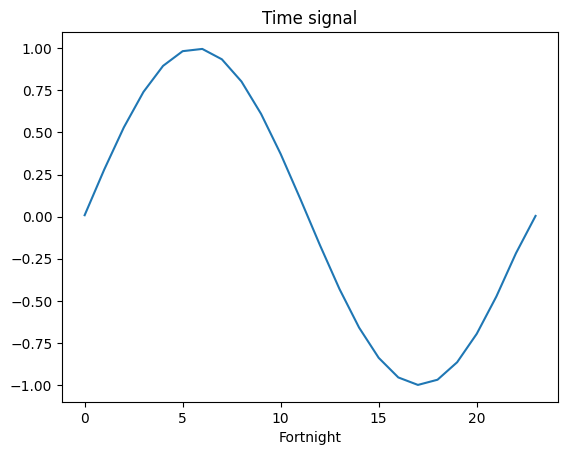

In [11]:
"""
Time in seconds is not a useful input for the model. Being meteorological data, it exhibits clear daily and annual periodicity.
There are many ways to deal with this periodicity. We chose to transform the date inputs into sine and cosine functions.
As we previously analyzed, the most important time dependence is annual, therefore, we will use a time signal with an annual period.
"""
day = 24*60*60
year = (365.2425)*day


ppna_df_feature_cross['date_signal'] = np.sin(ppna_df_feature_cross['timestamp_date'] * (2 * np.pi / year))

plt.plot(np.array(ppna_df_feature_cross['date_signal'])[:24]) #25 samples is nearly a year (15 * 24 = 360 days) and is shown to represent a full period of the temporal signal.
plt.xlabel('Fortnight')
plt.title('Time signal')



We divide the dataframe into three sections (train, test, validation) with roughly a 70-20-10 distribution. As we have 20 years of data, it is going to be diveded into 14 years, 4 years and 2 years (70%, 20% and 10%). The samples are divided secuentially to improve the RNN performance, following a training - validation - testing order.

- The **training set** is going to be fed to the model in order for it to learn the distinctive patterns and causalities for the input data and the future ppna.

- The **validation set** provides a way for the model to evaluate it's predictive capability and check if it is not just learning how to handle training data.

- The **testing set** is used further along the way, as a way to test the model's predictive effectieness with data that it has never seen before.

The resulting distribution of the dataset will resemble the following graph.

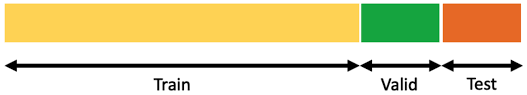


In [17]:
train_df_feature_cross = data.DataManager(ppna_df_feature_cross[ppna_df_feature_cross['date'] < '2014-01-01'][[ 'date_signal', 'ppt','temp', 'ppna','cluster_0','cluster_1','cluster_2','cluster_3','cluster_4','cluster_5','cluster_6','cluster_7']])
val_df_feature_cross =  data.DataManager(ppna_df_feature_cross[(ppna_df_feature_cross['date'] >= '2014-01-01') & (ppna_df_feature_cross['date'] < '2019-01-01')][[ 'date_signal','ppt', 'temp', 'ppna','cluster_0','cluster_1','cluster_2','cluster_3','cluster_4','cluster_5','cluster_6','cluster_7']])
test_df_feature_cross = data.DataManager(ppna_df_feature_cross[ppna_df_feature_cross['date'] >= '2019-01-01'][['date_signal','ppt','temp', 'ppna','cluster_0', 'cluster_1', 'cluster_2', 'cluster_3', 'cluster_4', 'cluster_5', 'cluster_6', 'cluster_7']])

In [18]:
"""
Normalization of every dataframe. The chosen normalization uses mean and standard deviation
Every Dataframe must be normalized by the same values, hence the train df mean and deviation are saved

(También es discutible que el modelo no debería tener acceso a valores futuros en el conjunto de entrenamiento 
durante el entrenamiento, y que esta normalización debería hacerse usando promedios móviles. Ese no es el enfoque 
de este tutorial, y los conjuntos de validación y prueba aseguran que obtenga métricas (algo) honestas. 
Entonces, en aras de la simplicidad, este tutorial usa un promedio simple.) 

https://medium.com/@spinjosovsky/normalize-data-before-or-after-split-of-training-and-testing-data-7b8005f81e26
https://datascience.stackexchange.com/questions/27615/should-we-apply-normalization-to-test-data-as-well
"""
train_df_feature_cross.normalize_data()
val_df_feature_cross.normalize_data()
test_df_feature_cross.normalize_data()

(date_signal     -0.000855
 ppt             58.136796
 temp            18.260310
 ppna           275.629525
 cluster_0        0.102000
 cluster_1        0.158000
 cluster_2        0.154000
 cluster_3        0.088000
 cluster_4        0.122667
 cluster_5        0.120667
 cluster_6        0.152000
 cluster_7        0.102667
 dtype: float64,
 date_signal      0.704494
 ppt             58.832369
 temp             4.671469
 ppna           123.051635
 cluster_0        0.302651
 cluster_1        0.364744
 cluster_2        0.360951
 cluster_3        0.283297
 cluster_4        0.328057
 cluster_5        0.325742
 cluster_6        0.359023
 cluster_7        0.303525
 dtype: float64)

--- 

# Recurrent Neuronal Network

In this section, we delve into the examination and analysis of various topologies within recurrent neural networks (RNNs) with the primary goal of estimating and predicting the productivity of forage production. Forage production, a critical aspect of agricultural ecosystems, can be influenced by a multitude of factors, and leveraging the capabilities of RNNs allows us to capture the temporal dependencies inherent in such dynamic systems.

The RNN technology is capable of pondering wether the inputs are correlated with eachother or not. It also has te ability to set cycles that constitute an "internal memory" that allows comparisons between the current data being analysed and the previous ones. This cycles, represented as delays, and the whole RNN structure are depicted in the following image.

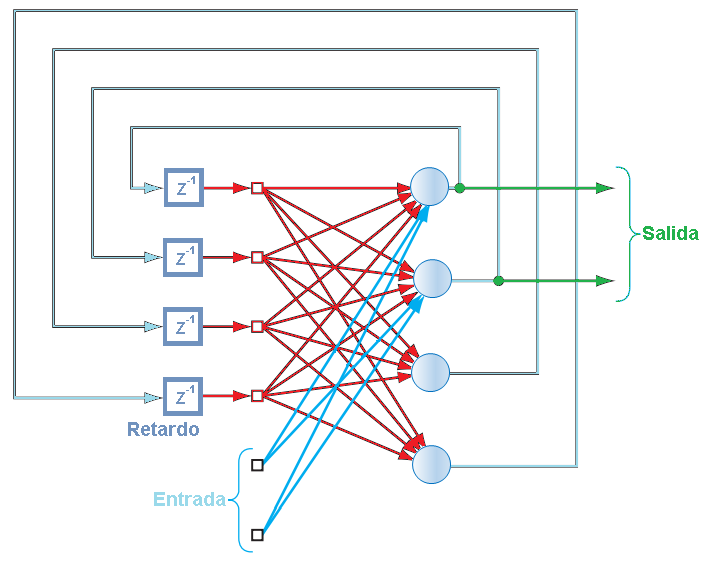



## LSTM - Multivariable 

We will embark on the construction of a Long Short-Term Memory (LSTM) neural network tailored for the PPNA. Leveraging the power of LSTM architecture, we aim to develop a robust model capable of capturing temporal dependencies within the data, ultimately enhancing our ability to forecast PPNA trends. Throughout this endeavor, we will explore the intricacies of LSTM networks, fine-tune model parameters, and implement effective training strategies to optimize predictive accuracy.

A recurrent model can learn to use a long history of inputs if it is relevant for the predictions the model makes. 
Here, the model will accumulate internal state over a year (24 samples) before making a single prediction for the next 15 days (1 sample).

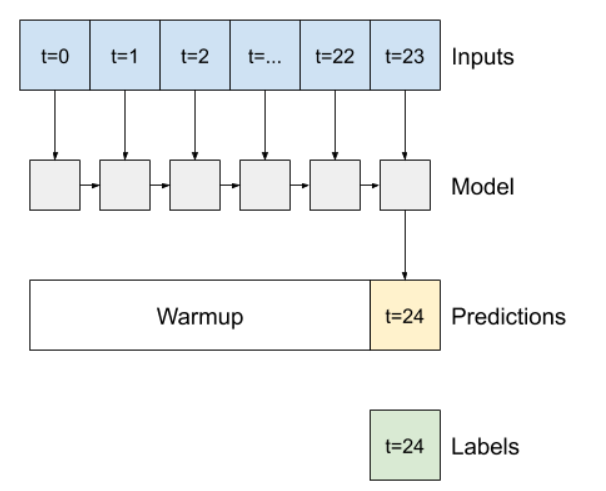

In [19]:
INPUT_STEPS = 24 #1 Year
OUTPUT_STEPS = 12 #The amount of days to be forecasted is given by the equation 15*OUTPUT_STEPS = # of days
train_sequence_feature_cross, train_labels_feature_cross = train_df_feature_cross.sequence_data_preparation(INPUT_STEPS, OUTPUT_STEPS)
val_sequence_feature_cross, val_labels_feature_cross = val_df_feature_cross.sequence_data_preparation(INPUT_STEPS, OUTPUT_STEPS)
test_sequence_feature_cross, test_labels_feature_cross = test_df_feature_cross.sequence_data_preparation(INPUT_STEPS, OUTPUT_STEPS)
print("train sequence: (num train data, past_data, features) ->", train_sequence_feature_cross.shape)
print("label sequence: (num train data, output_steps) -> ", test_labels_feature_cross.shape)

train sequence: (num train data, past_data, features) -> (448465, 24, 12)
label sequence: (num train data, output_steps) ->  (68965, 12)


In this section, every model tested has at least one LSTM layer, so let's remember how they work.

Long Short Term Memory is a type of neural network designed to solve the Vanishing Gradient problem and the Exploding Gradient Problem that the basic Recurrent Neural Network posed. The structure of a single unit is 

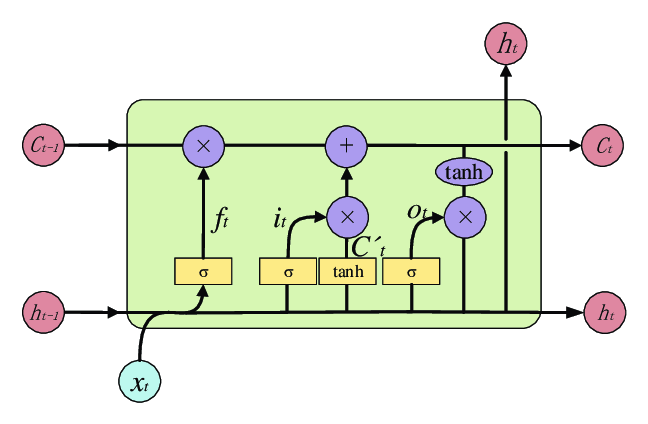

On the left side we can see the input data that arrives to the layer, which requires temporal info. x_t represents the information from the previous LSTM unit. On the right, the outputs of the unit serve as the inputs for the following step. Inside the square, the point is to make the Neural Network remember the important information and for it to "forget" the rest. As the time frame progresses, the oldest data starts to loose it's value and the LSTM unit filters it with the sigmoid functions, which act as a valve for the data flow. The tanh functions allow the new information to be passed on with a certain weight to represent it's importance.

In [20]:
"""
If you want to create a new model it has to be defined in /src/model
"""
modelLstm= models.modelLstm(INPUT_STEPS, OUTPUT_STEPS, train_df_feature_cross.shape[1], 1)

"""
The .fit method is a crucial step in the machine learning workflow, where a model learns patterns and relationships 
from a training dataset. During the training process, the model adjusts its internal parameters based on the input 
data and corresponding target values. The goal is to minimize the difference between the model's predictions and the
 actual target values. The training process involves iteratively updating the model parameters through techniques like 
 gradient descent or other optimization algorithms.
"""

EPOCHS = 5
history = modelLstm.fit(train_sequence_feature_cross, train_labels_feature_cross, validation_data=(val_sequence_feature_cross,val_labels_feature_cross), epochs=EPOCHS, batch_size=32)
modelLstm.save('../models/modelsupuestoideal')

"""
If you want to use a serialized model change the variable modelName, load from /models/ and comment the above block of code 
"""
#modelName = 'modelLstm128'
#model = tf.keras.models.load_model(f'../models/{modelName}')


Epoch 1/5

14015/14015 [==============================] - 240s 16ms/step - loss: 0.5132 - root_mean_squared_error: 0.7163 - val_loss: 0.2427 - val_root_mean_squared_error: 0.4927
Epoch 2/5
14015/14015 [==============================] - 240s 17ms/step - loss: 0.2619 - root_mean_squared_error: 0.5118 - val_loss: 0.2308 - val_root_mean_squared_error: 0.4805
Epoch 3/5
14015/14015 [==============================] - 258s 18ms/step - loss: 0.2442 - root_mean_squared_error: 0.4942 - val_loss: 0.2337 - val_root_mean_squared_error: 0.4835
Epoch 4/5
14015/14015 [==============================] - 267s 19ms/step - loss: 0.2324 - root_mean_squared_error: 0.4821 - val_loss: 0.2374 - val_root_mean_squared_error: 0.4873
Epoch 5/5
14015/14015 [==============================] - 1659s 118ms/step - loss: 0.2234 - root_mean_squared_error: 0.4727 - val_loss: 0.2417 - val_root_mean_squared_error: 0.4916
INFO:tensorflow:Assets written to: ../models/modelsupuestoideal\assets


INFO:tensorflow:Assets written to: ../models/modelsupuestoideal\assets


'\nIf you want to use a serialized model change the variable modelName, load from /models/ and comment the above block of code \n'

Now we will plot the values of root mean squared error and loss for each epoch regarding the training and validation set. 

- The squared error provides a clear way to evaluate how the predictions are going to relate to the actual values. Hence, we want it as close to 0 as possible.
- The loss value, however, is not to be overlooked. It remains a key factor to determine wether the model is overfitting or not. There are two main aspects to be aware of: first, we don't want the validation loss to grow over time, as that means the model is becoming too familiar with the training data and therefore starts losing it's ability to predict. Furthermore, we want for both validation loss and training loss to be similar, as in that case the model will be accurate in predicting training labels but not anything else, resulting in overfitting.

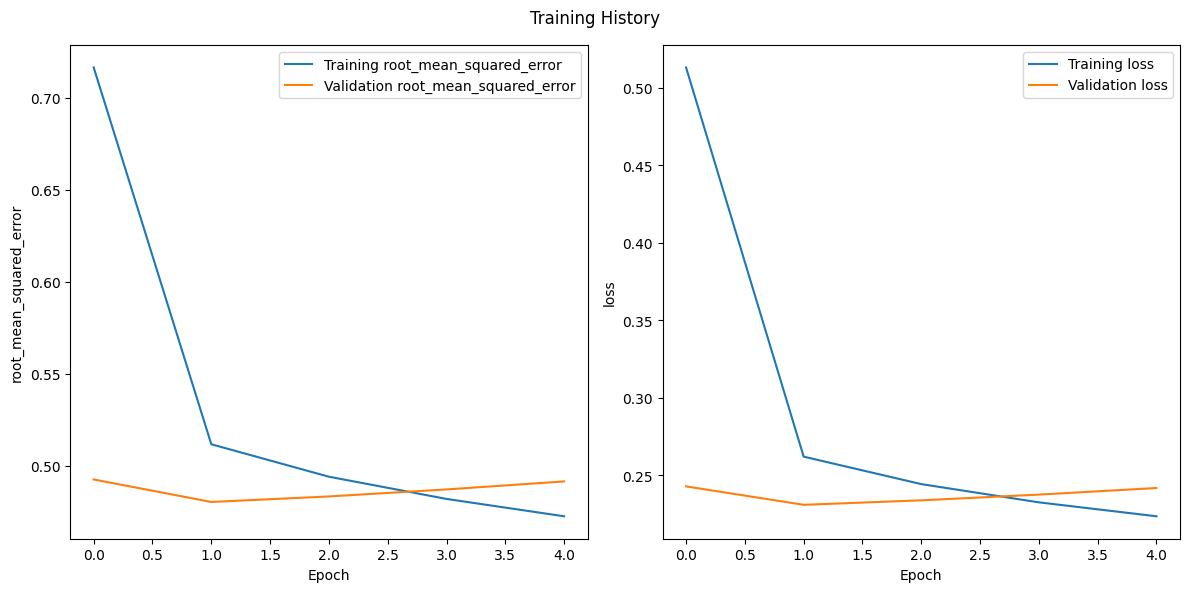

In [21]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

# plot training history
reporting.plot_training_history(axes[0], history, "root_mean_squared_error")
reporting.plot_training_history(axes[1], history, "loss")

fig.suptitle("Training History")
fig.tight_layout()
plt.show()


Now it's time to see how the model behaves in the testing phase. To do so, we can plot the predicted values for a fixed position next to the measured ones for the first 6 months of the testing dataset. As the model has never seen said values before, the result may show accurately it's performance. The chosen position is completely arbitrary and can be replicated for every point in the dataset, although in theory the precission should be statistically similar.

interactive(children=(IntSlider(value=0, description='Fortnight:', layout=Layout(margin='0px 0px 0px 0px', wid…

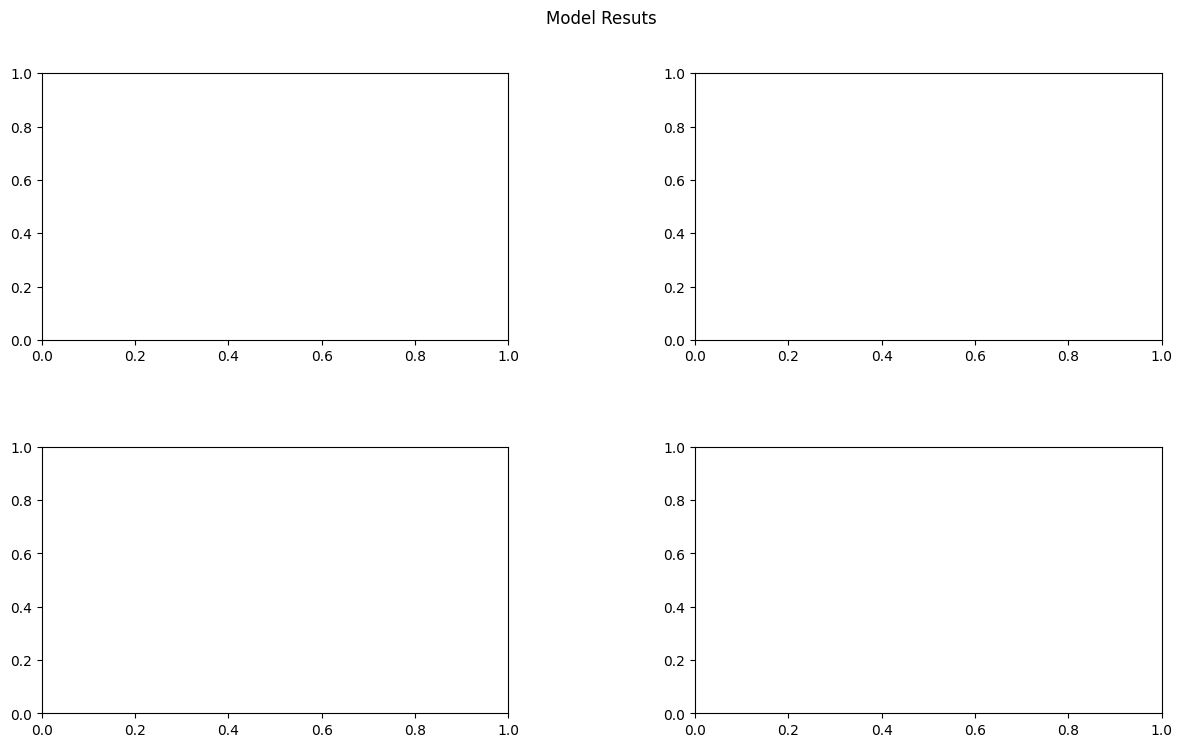

In [33]:
index_slider = widgets.IntSlider(min=0, max=OUTPUT_STEPS-2 , step=1, value=0, description='Fortnight:', layout=widgets.Layout(width='60%', margin='0px 0px 0px 0px'))

def update_plot(index):
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 8))
    fig.suptitle('Model Resuts')
    plt.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.9, wspace=0.4, hspace=0.4)
    reporting.plot_result_in_fixed_position(axes[0,0],ppna_df_feature_cross['longitude'][400000], ppna_df_feature_cross['latitude'][400000],index, modelLstm, test_df_feature_cross,INPUT_STEPS,OUTPUT_STEPS)
    reporting.plot_result_in_fixed_position(axes[0,1],ppna_df_feature_cross['longitude'][0], ppna_df_feature_cross['latitude'][0],index,  modelLstm, test_df_feature_cross,INPUT_STEPS,OUTPUT_STEPS)
    reporting.plot_result_in_fixed_position(axes[1,0],ppna_df_feature_cross['longitude'][10000], ppna_df_feature_cross['latitude'][10000],index,  modelLstm, test_df_feature_cross,INPUT_STEPS,OUTPUT_STEPS)
    reporting.plot_result_in_fixed_position(axes[1,1],ppna_df_feature_cross['longitude'][30000], ppna_df_feature_cross['latitude'][30000],index,   modelLstm, test_df_feature_cross,INPUT_STEPS,OUTPUT_STEPS)
    


widgets.interactive(update_plot, index=index_slider)

## Average predictions per Cluster

Next section will make predictions of ppna for each Cluster individualy. 
With the estimated average for each Cluster, there will be a plotted map with the predicted ppna.

First separate different test for each cluster

In [22]:
test_df_feature_cross_cluster0 = test_df_feature_cross[test_df_feature_cross.cluster_0 != 0]
test_df_feature_cross_cluster1 = test_df_feature_cross[test_df_feature_cross.cluster_1 != 0]
test_df_feature_cross_cluster2 = test_df_feature_cross[test_df_feature_cross.cluster_2 != 0]
test_df_feature_cross_cluster3 = test_df_feature_cross[test_df_feature_cross.cluster_3 != 0]
test_df_feature_cross_cluster4 = test_df_feature_cross[test_df_feature_cross.cluster_4 != 0]
test_df_feature_cross_cluster5 = test_df_feature_cross[test_df_feature_cross.cluster_5 != 0]
test_df_feature_cross_cluster6 = test_df_feature_cross[test_df_feature_cross.cluster_6 != 0]
test_df_feature_cross_cluster7 = test_df_feature_cross[test_df_feature_cross.cluster_7 != 0]


In [23]:
test_df_feature_cross_cluster0 = data.DataManager(test_df_feature_cross_cluster0)
test_df_feature_cross_cluster1 = data.DataManager(test_df_feature_cross_cluster1)
test_df_feature_cross_cluster2 = data.DataManager(test_df_feature_cross_cluster2)
test_df_feature_cross_cluster3 = data.DataManager(test_df_feature_cross_cluster3)
test_df_feature_cross_cluster4 = data.DataManager(test_df_feature_cross_cluster4)
test_df_feature_cross_cluster5 = data.DataManager(test_df_feature_cross_cluster5)
test_df_feature_cross_cluster6 = data.DataManager(test_df_feature_cross_cluster6)
test_df_feature_cross_cluster7 = data.DataManager(test_df_feature_cross_cluster7)

In [24]:
test_sequence_cluster0, test_labels_cluster0 = test_df_feature_cross_cluster0.sequence_data_preparation(INPUT_STEPS, OUTPUT_STEPS)
test_sequence_cluster1, test_labels_cluster1 = test_df_feature_cross_cluster1.sequence_data_preparation(INPUT_STEPS, OUTPUT_STEPS)
test_sequence_cluster2, test_labels_cluster2 = test_df_feature_cross_cluster2.sequence_data_preparation(INPUT_STEPS, OUTPUT_STEPS)
test_sequence_cluster3, test_labels_cluster3 = test_df_feature_cross_cluster3.sequence_data_preparation(INPUT_STEPS, OUTPUT_STEPS)
test_sequence_cluster4, test_labels_cluster4 = test_df_feature_cross_cluster4.sequence_data_preparation(INPUT_STEPS, OUTPUT_STEPS)
test_sequence_cluster5, test_labels_cluster5 = test_df_feature_cross_cluster5.sequence_data_preparation(INPUT_STEPS, OUTPUT_STEPS)
test_sequence_cluster6, test_labels_cluster6 = test_df_feature_cross_cluster6.sequence_data_preparation(INPUT_STEPS, OUTPUT_STEPS)
test_sequence_cluster7, test_labels_cluster7 = test_df_feature_cross_cluster7.sequence_data_preparation(INPUT_STEPS, OUTPUT_STEPS)


Make predictions for each cluster

In [25]:
predictions_cluster0 = modelLstm.predict(test_sequence_cluster0)
predictions_cluster1 = modelLstm.predict(test_sequence_cluster1)
predictions_cluster2 = modelLstm.predict(test_sequence_cluster2)
predictions_cluster3 = modelLstm.predict(test_sequence_cluster3)
predictions_cluster4 = modelLstm.predict(test_sequence_cluster4)
predictions_cluster5 = modelLstm.predict(test_sequence_cluster5)
predictions_cluster6 = modelLstm.predict(test_sequence_cluster6)
predictions_cluster7 = modelLstm.predict(test_sequence_cluster7)

221/221 [==============================] - 1s 6ms/step


Get the average PPNA for each cluster

In [26]:
def get_average(predictions_cluster):
    predictions_vector = []
    for i in range(0, OUTPUT_STEPS):
        cluster_avg = np.mean(predictions_cluster[:, i])
        predictions_vector.append(cluster_avg)
    return predictions_vector

In [27]:
avg_cluster0 = get_average(test_labels_cluster0)
avg_cluster1 = get_average(test_labels_cluster1)
avg_cluster2 = get_average(test_labels_cluster2)
avg_cluster3 = get_average(test_labels_cluster3)
avg_cluster4 = get_average(test_labels_cluster4)
avg_cluster5 = get_average(test_labels_cluster5)
avg_cluster6 = get_average(test_labels_cluster6)
avg_cluster7 = get_average(test_labels_cluster7)

In [28]:
predictions_avg_cluster0 = get_average(predictions_cluster0)
predictions_avg_cluster1 = get_average(predictions_cluster1)
predictions_avg_cluster2 = get_average(predictions_cluster2)
predictions_avg_cluster3 = get_average(predictions_cluster3)
predictions_avg_cluster4 = get_average(predictions_cluster4)
predictions_avg_cluster5 = get_average(predictions_cluster5)
predictions_avg_cluster6 = get_average(predictions_cluster6)
predictions_avg_cluster7 = get_average(predictions_cluster7)

In [30]:
predictions_avg_cluster0

[-0.16860166,
 -0.06641327,
 -0.09597831,
 -0.093940385,
 -0.036483563,
 -0.0099048065,
 -0.0600287,
 -0.03856271,
 -0.044164717,
 -0.03065946,
 -0.066304006,
 -0.04898936]

In [31]:
[round(value, 4) for value in predictions_avg_cluster0]

[-0.1686,
 -0.0664,
 -0.096,
 -0.0939,
 -0.0365,
 -0.0099,
 -0.06,
 -0.0386,
 -0.0442,
 -0.0307,
 -0.0663,
 -0.049]

In [32]:
predictions_avg_cluster0_round = [round(value, 4) for value in predictions_avg_cluster0]
predictions_avg_cluster1_round = [round(value, 4) for value in predictions_avg_cluster1]
predictions_avg_cluster2_round = [round(value, 4) for value in predictions_avg_cluster2]
predictions_avg_cluster3_round = [round(value, 4) for value in predictions_avg_cluster3]
predictions_avg_cluster4_round = [round(value, 4) for value in predictions_avg_cluster4]
predictions_avg_cluster5_round = [round(value, 4) for value in predictions_avg_cluster5]
predictions_avg_cluster6_round = [round(value, 4) for value in predictions_avg_cluster6]
predictions_avg_cluster7_round = [round(value, 4) for value in predictions_avg_cluster7]

Plot the map of cluster with the ppna label

In [34]:
'''
Prints map with cluster contours obtained from the dataset locations. It uses a convex_hull (hull= shell, contour)
which sets the simplest contour to be drawn around a given set of points (like a rubber band on tacks)
'''


#Create a dictionary with points grouped by clusters. The cluster id is the dictionary key and the coordinates are the dictionary data
clustered_points = {}
for _, row in X.iterrows():
    cluster_id = int(row["cluster"])
    if cluster_id not in clustered_points:
        clustered_points[cluster_id] = []
    clustered_points[cluster_id].append((row["latitude"], row["longitude"]))

# Create a polygon dictionary. Key=cluster id; data=convex hull.
cluster_polygons = {}
for cluster_id, points in clustered_points.items():
    multipoint = MultiPoint(points)
    convex_hull = multipoint.convex_hull
    cluster_polygons[cluster_id] = convex_hull

map = folium.Map(location=[ppna_df_feature_cross['latitude'].mean(), ppna_df_feature_cross['longitude'].mean()], zoom_start=6)

for cluster_id, polygon in cluster_polygons.items():
    coords = list(polygon.exterior.coords)
    folium.Polygon(locations=coords, color=COLORS[cluster_id], fill=True, fill_color=COLORS[cluster_id], fill_opacity=0.3).add_to(map)


map

In [41]:
import folium

ppna_avg_by_cluster = {
    0: predictions_avg_cluster0_round,
    1: predictions_avg_cluster1_round,
    2: predictions_avg_cluster2_round,
    3: predictions_avg_cluster3_round,
    4: predictions_avg_cluster4_round,
    5: predictions_avg_cluster5_round,
    6: predictions_avg_cluster6_round,
    7: predictions_avg_cluster7_round,
    
}


map_clusters = folium.Map(location=[ppna_df_feature_cross['latitude'].mean(), ppna_df_feature_cross['longitude'].mean()], zoom_start=6)


interval_index = 0


for cluster_id, polygon in cluster_polygons.items():
    coords = list(polygon.exterior.coords)
    

    folium.Polygon(locations=coords, color=COLORS[cluster_id], fill=True, fill_color=COLORS[cluster_id], fill_opacity=0.3).add_to(map_clusters)

    ppna_avg = ppna_avg_by_cluster[cluster_id][interval_index]
    
  
    ppna_label = "Cluster {}: {:.4f} (Intervalo de tiempo: {}-{} días)".format(cluster_id, ppna_avg, interval_index*15, (interval_index+1)*15)
    #folium.Marker(location=[polygon.centroid.coords[0][1], polygon.centroid.coords[0][0]], 
                  #icon=folium.DivIcon(html=f'<div>{ppna_label}</div>')).add_to(map_clusters)



    counter = 0
for centroid, ppna_label in zip(centers, [predictions_avg_cluster0_round, predictions_avg_cluster1_round, predictions_avg_cluster2_round, predictions_avg_cluster3_round, predictions_avg_cluster4_round, predictions_avg_cluster5_round, predictions_avg_cluster6_round, predictions_avg_cluster7_round]):
    folium.CircleMarker(
        location=[centroid[0], centroid[1]],
        radius=4, 
        weight=2, 
        fill=True, 
        fill_color=COLORS[counter],
        color=COLORS[counter]
    ).add_to(map_clusters)

    folium.Marker(
        location=[centroid[0], centroid[1]],
        icon=folium.DivIcon(
            icon_size=(150,36),
            icon_anchor=(7,20),
            html=f'<div style="font-size: 12pt; color : black">{ppna_label[interval_index]}</div>'
        )
    ).add_to(map_clusters)

    counter += 1
    
    
map_clusters
